# Data Glacier Internship Group Project: Bank Marketing Campaign

## Predicting Whether a Client Will Subscribe for a Term Deposit

In [68]:
#Importing packages that we might need
#If you want to import more packages, just do it here

import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split 
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
import tensorflow as tf
import keras
from keras.layers import Dense, Activation

sns.set()

### Loading the Data

In [2]:
bank = pd.read_csv('data/bank.csv', sep = ';', header = 0) #smaller dataframe
bank_full = pd.read_csv('data/bank-full.csv', sep = ';', header = 0) #full dataframe

In [3]:
bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [4]:
bank_full.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


### Inspecting the Data, Looking for Problems in the Data

#### Looking for Missing/NA Values

In [5]:
print("Missing values in the small dataframe:", bank.isnull().sum().sum())
print("Missing values in the full dataframe:", bank_full.isnull().sum().sum())


Missing values in the small dataframe: 0
Missing values in the full dataframe: 0


There are no missing values in either of the datasets, so we will not need to deal with missing data.

In [6]:
#Checking for '999' values in 'pday' variable (999 means client was not previously contacted - so we should remove these 
# values if we find any)

print("Missing values in the small dataframe:", bank.loc[bank['pdays']==999].sum().sum())
print("Missing values in the full dataframe:", bank_full.loc[bank_full['pdays']==999].sum().sum())

Missing values in the small dataframe: 0.0
Missing values in the full dataframe: 0.0


There are no '999' values in the 'pdays' variable.

#### Looking for Skewed Data

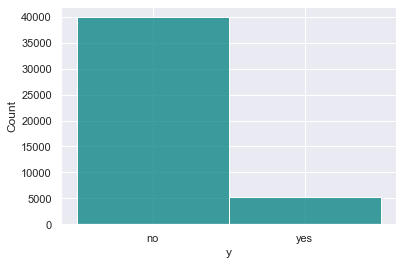

In [7]:
y_hist = sns.histplot(data=bank_full, x = 'y', color = 'teal')

The dataset is imbalanced, there are significantly more 'no' than 'yes'

array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'balance'}>,
        <AxesSubplot:title={'center':'day'}>],
       [<AxesSubplot:title={'center':'duration'}>,
        <AxesSubplot:title={'center':'campaign'}>,
        <AxesSubplot:title={'center':'pdays'}>],
       [<AxesSubplot:title={'center':'previous'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

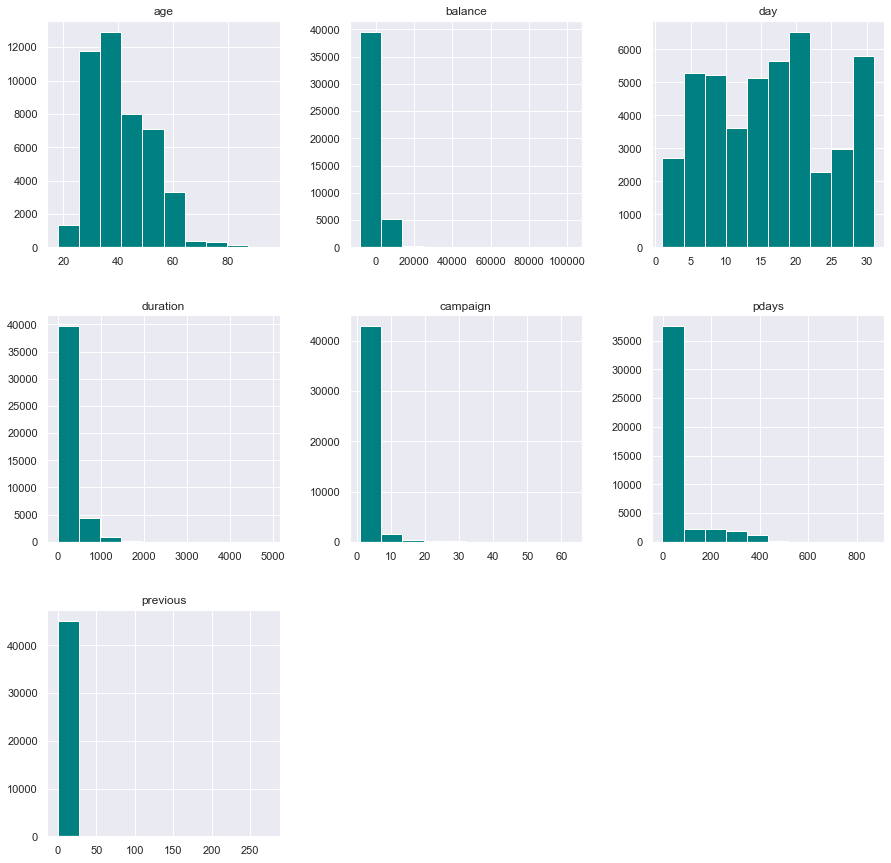

In [8]:
bank_full.hist(figsize=(15, 15),color='teal')

Most numerical variables (balance, duration, campaign, and pdays) are strongly skewed to the right. The 'previous' variable may also be skewed right. 'Age' appears to be slightly skewed right, while the 'day' variable appears to follow an approximate normal distribution. 

### Looking for Outliers

#### Using Data Visualization to Find Outliers (Only for Numerical Variables)

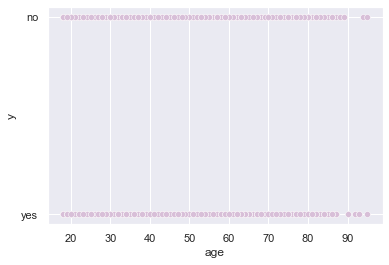

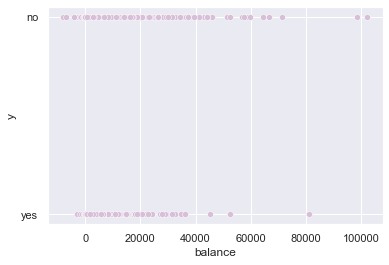

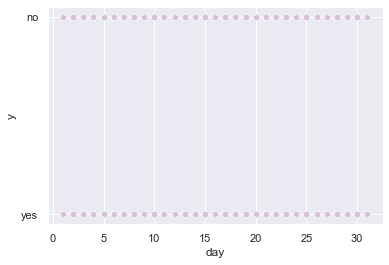

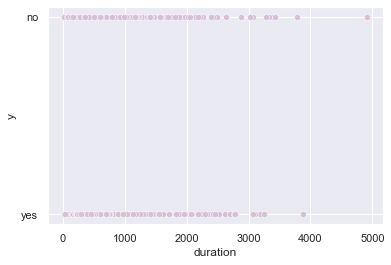

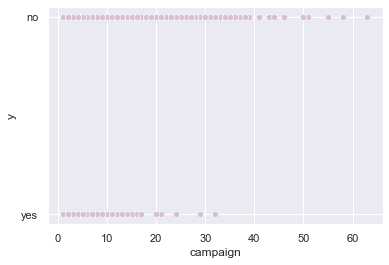

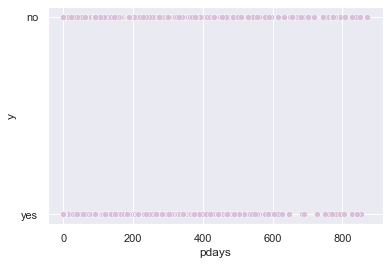

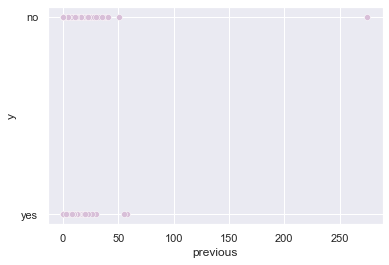

In [9]:
#Scatterplots

num_cols = ['age','balance','day','duration','campaign', 'pdays', 'previous']

for col in num_cols:
    plt.figure()
    sns.scatterplot(x=col, y='y', data=bank_full,color='thistle')

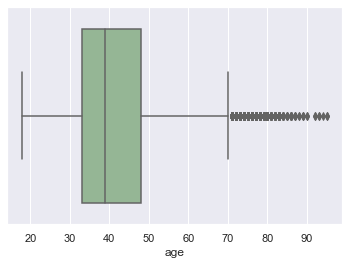

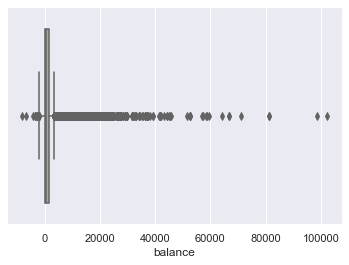

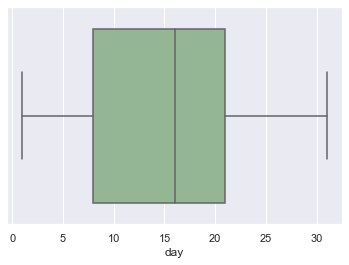

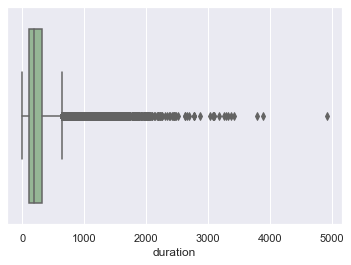

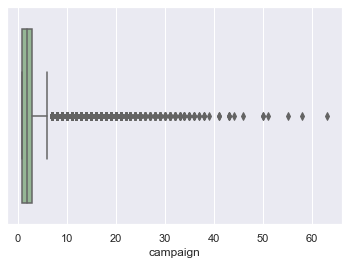

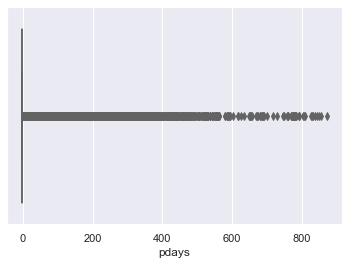

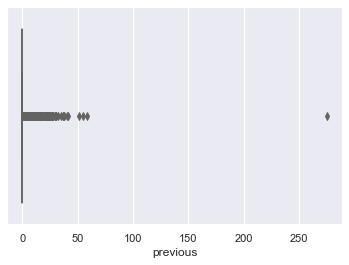

In [10]:
#Box Plots

num_cols = ['age','balance','day','duration','campaign', 'pdays', 'previous']

for col in num_cols:
    plt.figure()
    sns.boxplot(x=col, data=bank_full,color='darkseagreen')

There are some small outliers in the 'age' variable. Other variables ('balance', 'duration', 'campaign', 'pdays', and 'previous') have some pretty large outliers. The 'previous' variable has a very large outlier, this may be an error and we should probably remove this value.

## Fixing Skewed Data

### pdays

In [11]:
# sqrt method
pdays_sqrt = np.sqrt(bank_full['pdays'])
pdays_sqrt.skew()

C:\Users\jane9\AppData\Local\R-MINI~1\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


-0.292640104073605

(array([ 148.,   91.,  605., 1562., 2184., 1607., 1878.,  121.,   29.,
          32.]),
 array([ 1.        ,  3.85127091,  6.70254183,  9.55381274, 12.40508365,
        15.25635456, 18.10762548, 20.95889639, 23.8101673 , 26.66143821,
        29.51270913]),
 <BarContainer object of 10 artists>)

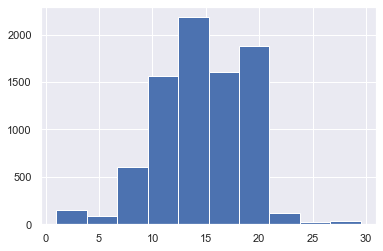

In [12]:
plt.hist(pdays_sqrt)

We can fix the right-skewed data for pdays with square root.

### duration

In [13]:
# log method
duration_log = np.log(bank_full['duration']+1)
duration_log.skew()

-0.45416422447582144

(array([5.0000e+00, 2.2000e+01, 4.8800e+02, 1.3520e+03, 4.1090e+03,
        1.4496e+04, 1.6216e+04, 7.0930e+03, 1.3850e+03, 4.5000e+01]),
 array([0.        , 0.85008605, 1.70017211, 2.55025816, 3.40034421,
        4.25043027, 5.10051632, 5.95060238, 6.80068843, 7.65077448,
        8.50086054]),
 <BarContainer object of 10 artists>)

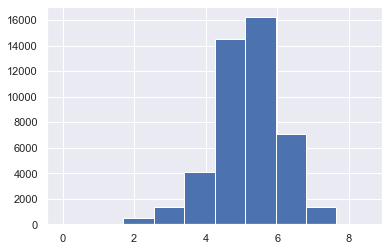

In [14]:
plt.hist(duration_log)

We can fix the right-skewed data for duration by adding 1 to all the data so the min is 1 and log the data.

### campaign

In [15]:
# Box-Cox method
campaign_boxcox = stats.boxcox(bank_full['campaign'])[0]
pd.Series(campaign_boxcox).skew()

0.16630337139412119

(array([17544.,     0.,     0., 12505.,     0.,  5521.,  5286.,  2893.,
         1175.,   287.]),
 array([0.        , 0.15712681, 0.31425362, 0.47138043, 0.62850724,
        0.78563405, 0.94276086, 1.09988767, 1.25701448, 1.41414129,
        1.5712681 ]),
 <BarContainer object of 10 artists>)

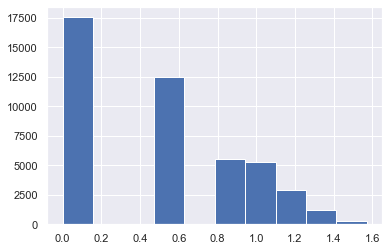

In [16]:
plt.hist(campaign_boxcox)

We can fix the right-skewed data for campaign with the box-cox method.

### previous

In [17]:
bank_full['previous'].min()

0

In [18]:
previous_log = np.log(bank_full['previous']+1)
pd.Series(previous_log).skew()

2.5161664491719806

(array([3.6954e+04, 4.8780e+03, 1.8560e+03, 1.0700e+03, 3.4500e+02,
        8.9000e+01, 1.5000e+01, 3.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([0.        , 0.56204009, 1.12408017, 1.68612026, 2.24816035,
        2.81020043, 3.37224052, 3.93428061, 4.49632069, 5.05836078,
        5.62040087]),
 <BarContainer object of 10 artists>)

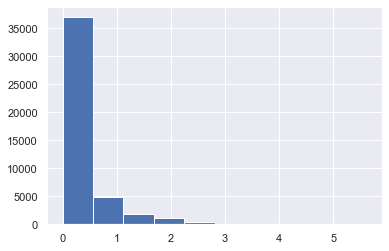

In [19]:
plt.hist(previous_log)

We can fix the right-skewed data for previous with the log + 1 method. 
(NOT SURE IF THERE IS A BETTER WAY TO DO THIS)

### balance

In [20]:
bank_full['balance'].min()

-8019

In [21]:
min_value = - bank_full['balance'].min() + 1
campaign_boxcox = stats.boxcox(bank_full['balance']+min_value)[0]
pd.Series(campaign_boxcox).skew()

-0.4030797007571244

(array([1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 7.8000e+01, 4.4907e+04, 2.2400e+02]),
 array([0.        , 0.92934116, 1.85868231, 2.78802347, 3.71736463,
        4.64670579, 5.57604694, 6.5053881 , 7.43472926, 8.36407041,
        9.29341157]),
 <BarContainer object of 10 artists>)

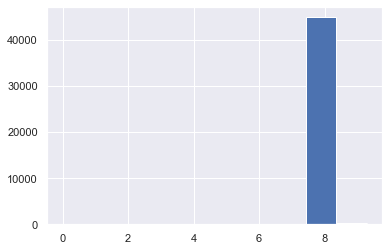

In [22]:
plt.hist(campaign_boxcox)

(NOT SURE IF THERE IS A BETTER WAY TO DO THIS)

## Preparing Data for Classification Models

### Creating Dummy Variables for Categorical Variables

In [23]:
target = np.where(bank_full['y'] == 'yes', 1, 0)

In [24]:
bank_full['y'] = target

In [25]:
cat=['job','marital','education','default','housing','loan','contact','month','poutcome']
for var in cat:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(bank_full[var], prefix=var)
    bank_full2=bank_full.join(cat_list)
    bank_full=bank_full2

In [26]:
bank_full.columns.values

array(['age', 'job', 'marital', 'education', 'default', 'balance',
       'housing', 'loan', 'contact', 'day', 'month', 'duration',
       'campaign', 'pdays', 'previous', 'poutcome', 'y', 'job_admin.',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed',
       'job_services', 'job_student', 'job_technician', 'job_unemployed',
       'job_unknown', 'marital_divorced', 'marital_married',
       'marital_single', 'education_primary', 'education_secondary',
       'education_tertiary', 'education_unknown', 'default_no',
       'default_yes', 'housing_no', 'housing_yes', 'loan_no', 'loan_yes',
       'contact_cellular', 'contact_telephone', 'contact_unknown',
       'month_apr', 'month_aug', 'month_dec', 'month_feb', 'month_jan',
       'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov',
       'month_oct', 'month_sep', 'poutcome_failure', 'poutcome_other',
       'poutcome_success', 'poutcome_unknown'], d

In [27]:
cat=['job','marital','education','default','housing','loan','contact','month','poutcome']
bank_var=bank_full.columns.values.tolist()
to_keep=[i for i in bank_var if i not in cat]

bank_final=bank_full[to_keep]
bank_final.columns.values

array(['age', 'balance', 'day', 'duration', 'campaign', 'pdays',
       'previous', 'y', 'job_admin.', 'job_blue-collar',
       'job_entrepreneur', 'job_housemaid', 'job_management',
       'job_retired', 'job_self-employed', 'job_services', 'job_student',
       'job_technician', 'job_unemployed', 'job_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'education_primary', 'education_secondary', 'education_tertiary',
       'education_unknown', 'default_no', 'default_yes', 'housing_no',
       'housing_yes', 'loan_no', 'loan_yes', 'contact_cellular',
       'contact_telephone', 'contact_unknown', 'month_apr', 'month_aug',
       'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
       'poutcome_failure', 'poutcome_other', 'poutcome_success',
       'poutcome_unknown'], dtype=object)

### Selecting Features

In [28]:
X = bank_final.loc[:, bank_final.columns != 'y'] #features
X_2 = bank_final.loc[:, ~bank_final.columns.isin(['y', 'duration'])]
y = bank_final['y'] #target variable

In [29]:
X.head()

,age,balance,day,duration,campaign,pdays,previous,job_admin.,job_blue-collar,job_entrepreneur,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,58,2143,5,261,1,-1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
1,44,29,5,151,1,-1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,33,2,5,76,1,-1,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1
3,47,1506,5,92,1,-1,0,0,1,0,...,0,0,1,0,0,0,0,0,0,1
4,33,1,5,198,1,-1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1


In [30]:
X_2.head()

,age,balance,day,campaign,pdays,previous,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,58,2143,5,1,-1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
1,44,29,5,1,-1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,33,2,5,1,-1,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,1
3,47,1506,5,1,-1,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
4,33,1,5,1,-1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1


In [31]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: y, dtype: int32

## Classification Models

### Logistic Regression

#### Splitting the Data

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X_2, y, train_size=0.7, random_state=42)

#### Scaling the Feature Variables

In [33]:
scaler = StandardScaler()

In [34]:
#Scaling the training data
scaled_X_train = X_train.copy()

In [35]:
#Scaling the training data
scaled_X_train[['age','balance','day','campaign','pdays','previous']] = scaler.fit_transform(scaled_X_train[['age','balance','day','campaign','pdays','previous']])

In [36]:
#Scaling the testing data
scaled_X_test = X_test.copy()

In [37]:
scaled_X_test[['age','balance','day','campaign','pdays','previous']] = scaler.fit_transform(scaled_X_test[['age','balance','day','campaign','pdays','previous']])

#### Building the Model and Making Predictions

In [102]:
log_reg = LogisticRegression(solver='liblinear')
log_reg.fit(scaled_X_train, y_train)

LogisticRegression(solver='liblinear')

In [103]:
y_pred = log_reg.predict(scaled_X_test)

#### Evaluating the Model

In [104]:
#Accuracy Score
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8921409613683279


In [105]:
#Confusion matrix
conf_mat = metrics.confusion_matrix(y_test, y_pred)
conf_mat

array([[11808,   158],
       [ 1305,   293]], dtype=int64)

In [106]:
#Classification report
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.99      0.94     11966
           1       0.65      0.18      0.29      1598

    accuracy                           0.89     13564
   macro avg       0.78      0.59      0.61     13564
weighted avg       0.87      0.89      0.86     13564



#### Logistic Regression Model with Duration Included

#### Scaling the Data

In [43]:
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X, y, train_size=0.7, random_state=42)

In [44]:
#Scaling the training data
scaled_X_train_d = X_train_d.copy()

scaled_X_train_d[['age','balance','day','campaign','pdays','previous']] = scaler.fit_transform(scaled_X_train_d[['age','balance','day','campaign','pdays','previous']])

In [45]:
#Scaling the testing data
scaled_X_test_d = X_test_d.copy()

scaled_X_test_d[['age','balance','day','campaign','pdays','previous']] = scaler.fit_transform(scaled_X_test_d[['age','balance','day','campaign','pdays','previous']])

#### Fitting and Training the Model, Making Predictions on the Testing Data

In [107]:
log_reg_dur = LogisticRegression(solver='liblinear')
log_reg_dur.fit(scaled_X_train_d, y_train_d)

LogisticRegression(solver='liblinear')

In [108]:
y_pred_d = log_reg_dur.predict(scaled_X_test_d)

#### Evaluating the Model with 'Duration' Included

In [109]:
#Accuracy Score
print("Accuracy:",metrics.accuracy_score(y_test_d, y_pred_d))

Accuracy: 0.8998820406959599


In [49]:
#Confusion matrix
conf_mat = metrics.confusion_matrix(y_test_d, y_pred_d)
conf_mat

array([[11657,   309],
       [ 1049,   549]], dtype=int64)

In [50]:
#probably going to add a heatmap of the confusion matrix here

In [51]:
#Classification report
print(metrics.classification_report(y_test_d, y_pred_d))

              precision    recall  f1-score   support

           0       0.92      0.97      0.94     11966
           1       0.64      0.34      0.45      1598

    accuracy                           0.90     13564
   macro avg       0.78      0.66      0.70     13564
weighted avg       0.88      0.90      0.89     13564



#### Hyperparameter Tuning to Find the Best Model (wasn't really sure how to do this, might fix later)

In [230]:
param_grid_lr = {
    'max_iter': [20, 50, 100, 200, 500, 1000],                      
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],   
    'class_weight': ['balanced']                                    
}

logModel_grid = GridSearchCV(estimator=LogisticRegression(random_state=1234), param_grid=param_grid_lr, verbose=1, cv=10, n_jobs=-1)
logModel_grid.fit(scaled_X_train, y_train)
print(logModel_grid.best_estimator_)

Fitting 10 folds for each of 30 candidates, totalling 300 fits


KeyboardInterrupt: 

In [ ]:
#Making predictions
y_pred_2 = logModel_grid.predict(scaled_X_test) 

In [80]:
#Checking accuracy score
logModel_grid.score(X, y)

0.8455022007918427

In [81]:
#Confusion matrix
conf_mat2 = metrics.confusion_matrix(y_test, y_pred_2)
conf_mat2

array([[10155,  1811],
       [  283,  1315]], dtype=int64)

In [ ]:
#probably going to add heatmap of confusion matrix here

In [82]:
#Classification report
print(metrics.classification_report(y_test, y_pred_2))

              precision    recall  f1-score   support

          no       0.97      0.85      0.91     11966
         yes       0.42      0.82      0.56      1598

    accuracy                           0.85     13564
   macro avg       0.70      0.84      0.73     13564
weighted avg       0.91      0.85      0.87     13564



Both of the models are accurate at predicting 'no', but are not very accurate at predicting 'yes.' This could possibly be due to the fact that the dataset is highly imbalanced (more 'no' than 'yes'). This means that we should try out additional models to improve the accuracy.

### Random Forest

#### Fitting and Training the Model, Making Predictions on the Testing Data

In [110]:
forest = RandomForestClassifier(n_estimators=300, random_state=42)
forest.fit(scaled_X_train, y_train)
y_pred = forest.predict(scaled_X_test)

#### Evaluating the Model

In [111]:
#Accuracy Score
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8929519315836036


In [112]:
conf_mat = metrics.confusion_matrix(y_test, y_pred)
conf_mat

array([[11721,   245],
       [ 1207,   391]], dtype=int64)

In [113]:
#Classification report
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.98      0.94     11966
           1       0.61      0.24      0.35      1598

    accuracy                           0.89     13564
   macro avg       0.76      0.61      0.65     13564
weighted avg       0.87      0.89      0.87     13564



#### Plotting Feature Importance

<BarContainer object of 20 artists>

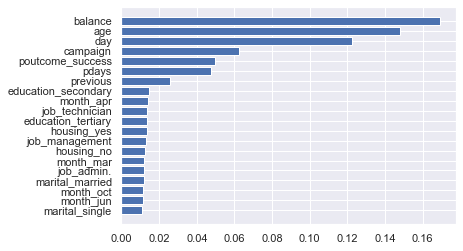

In [114]:
#20 most important features (will fix later)
sorted_index = forest.feature_importances_.argsort()
plt.barh(scaled_X_train.columns[sorted_index[-20 : ]], forest.feature_importances_[sorted_index[-20 : ]])

<BarContainer object of 20 artists>

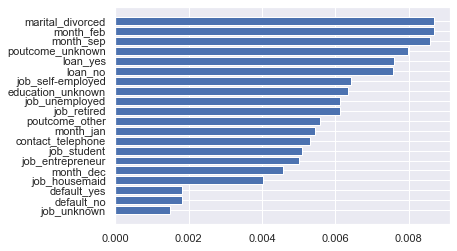

In [115]:
#20 least important features (will fix later)
sorted_index = forest.feature_importances_.argsort()
plt.barh(scaled_X_train.columns[sorted_index[ : 20 ]], forest.feature_importances_[sorted_index[ : 20]])

### Random Forest Model with Duration Included

#### Fitting and Training the Model, Making Predictions on the Testing Data

In [282]:
forest_d = RandomForestClassifier(n_estimators=300, random_state=42)
forest_d.fit(scaled_X_train_d, y_train_d)

RandomForestClassifier(n_estimators=300, random_state=42)

In [283]:
y_pred = forest_d.predict(scaled_X_test_d)

#### Evaluating the Model

In [284]:
#Checking accuracy score
forest_d.score(scaled_X_test_d, y_test_d)

0.90555883220289

In [285]:
#Confusion matrix
conf_mat = metrics.confusion_matrix(y_test_d, y_pred_d)
conf_mat

array([[11657,   309],
       [ 1049,   549]], dtype=int64)

In [286]:
#Classification report
print(metrics.classification_report(y_test_d, y_pred_d))

              precision    recall  f1-score   support

           0       0.92      0.97      0.94     11966
           1       0.64      0.34      0.45      1598

    accuracy                           0.90     13564
   macro avg       0.78      0.66      0.70     13564
weighted avg       0.88      0.90      0.89     13564



### Support Vector Machine (SVM)

#### Fitting and Training The Model, Making Predictions on Testing Data

In [45]:
svm_cl = svm.SVC(kernel='linear')

In [46]:
svm_cl.fit(scaled_X_train, y_train)

SVC(kernel='linear')

In [47]:
y_pred = svm_cl.predict(scaled_X_test)

#### Evaluating the Model

In [48]:
#Accuracy Score
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8921409613683279


In [49]:
#Confusion matrix
conf_mat3 = metrics.confusion_matrix(y_test, y_pred)
conf_mat3

array([[11802,   164],
       [ 1299,   299]], dtype=int64)

In [50]:
#Classification report
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.99      0.94     11966
           1       0.65      0.19      0.29      1598

    accuracy                           0.89     13564
   macro avg       0.77      0.59      0.62     13564
weighted avg       0.87      0.89      0.86     13564



### Support Vector Machine (SVM) Model with Duration Included

#### Fitting and Training the Model, Making Predictions on the Testing Data

In [ ]:
svm_d = svm.SVC(kernel='linear')
svm_d.fit(scaled_X_train_d, y_train_d)

In [ ]:
y_pred = svm_cl.predict(scaled_X_test_d)

#### Evaluating the Model

In [ ]:
#Accuracy Score
print("Accuracy:",metrics.accuracy_score(y_test_d, y_pred))

In [ ]:
#Confusion matrix
conf_mat3 = metrics.confusion_matrix(y_test_d, y_pred)
conf_mat3

### Naive Bayes Classifier

#### Fitting and Training the Model, Making Predictions on the Testing Data

In [47]:
nb = GaussianNB()

In [48]:
nb.fit(scaled_X_train,y_train)

GaussianNB()

In [49]:
y_pred = nb.predict(scaled_X_test)

#### Evaluating the Model

In [50]:
#Accuracy Score
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8372898849896786


In [51]:
#Confusion matrix
conf_mat_nb = metrics.confusion_matrix(y_test, y_pred)
conf_mat_nb

array([[10635,  1331],
       [  876,   722]], dtype=int64)

In [52]:
#Classification report
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.89      0.91     11966
           1       0.35      0.45      0.40      1598

    accuracy                           0.84     13564
   macro avg       0.64      0.67      0.65     13564
weighted avg       0.86      0.84      0.85     13564



### Naive Bayes Classifier with Duration Included

#### Fitting and Training the Model, Making Predictions on the Testing Data

In [53]:
nb.fit(scaled_X_train_d,y_train_d)

GaussianNB()

In [54]:
y_pred = nb.predict(scaled_X_test_d)

#### Evaluating the Model

In [55]:
#Accuracy Score
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8470952521380124


In [56]:
#Confusion matrix
conf_mat_nb = metrics.confusion_matrix(y_test, y_pred)
conf_mat_nb

array([[10679,  1287],
       [  787,   811]], dtype=int64)

In [57]:
#Classification report
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.89      0.91     11966
           1       0.39      0.51      0.44      1598

    accuracy                           0.85     13564
   macro avg       0.66      0.70      0.68     13564
weighted avg       0.87      0.85      0.86     13564



### Artificial Neural Network (Multi-Layer Perceptron)

#### Fitting and Training the Model, Making Predictions on the Testing Data

In [65]:
model = keras.Sequential()

In [69]:
#Input layer/First hidden layer
model.add(Dense(units=10, input_dim=50, kernel_initializer='uniform', activation='relu'))

In [70]:
#Second hidden layer
model.add(Dense(units=6, kernel_initializer='uniform', activation='relu')) 

In [71]:
#Output layer
model.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))

In [72]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [74]:
#Fitting the model on the training data
ann = model.fit(scaled_X_train,y_train, batch_size=10 , epochs=50, verbose=1)

Epoch 1/50
3165/3165 [==============================] - 4s 1ms/step - loss: 0.2891 - accuracy: 0.8940
Epoch 2/50
3165/3165 [==============================] - 3s 1ms/step - loss: 0.2883 - accuracy: 0.8941
Epoch 3/50
3165/3165 [==============================] - 3s 1ms/step - loss: 0.2885 - accuracy: 0.8945
Epoch 4/50
3165/3165 [==============================] - 4s 1ms/step - loss: 0.2879 - accuracy: 0.8948
Epoch 5/50
3165/3165 [==============================] - 4s 1ms/step - loss: 0.2875 - accuracy: 0.8943
Epoch 6/50
3165/3165 [==============================] - 4s 1ms/step - loss: 0.2871 - accuracy: 0.8953
Epoch 7/50
3165/3165 [==============================] - 4s 1ms/step - loss: 0.2865 - accuracy: 0.8956
Epoch 8/50
3165/3165 [==============================] - 4s 1ms/step - loss: 0.2861 - accuracy: 0.8956
Epoch 9/50
3165/3165 [==============================] - 4s 1ms/step - loss: 0.2861 - accuracy: 0.8951
Epoch 10/50
3165/3165 [==============================] - 4s 1ms/step - loss: 0.285

In [84]:
y_pred = model.predict(scaled_X_test)

424/424 [==============================] - 0s 835us/step


In [86]:
y_pred = (y_pred > 0.5)

#### Evaluating the Model

In [89]:
#Accuracy Score
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8924358596284282


In [87]:
conf_mat = metrics.confusion_matrix(y_test, y_pred)
conf_mat

array([[11688,   278],
       [ 1181,   417]], dtype=int64)

In [88]:
#Classification report
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.98      0.94     11966
           1       0.60      0.26      0.36      1598

    accuracy                           0.89     13564
   macro avg       0.75      0.62      0.65     13564
weighted avg       0.87      0.89      0.87     13564



### Artificial Neural Network (Multi-Layer Perceptron) With Duration Included

#### Fitting and Training the Model, Making Predictions on the Testing Data

In [90]:
model_dur = keras.Sequential()

In [91]:
#Input layer/First hidden layer
model_dur.add(Dense(units=10, input_dim=51, kernel_initializer='uniform', activation='relu'))

In [92]:
#Second hidden layer
model_dur.add(Dense(units=6, kernel_initializer='uniform', activation='relu')) 

In [93]:
#Output layer
model_dur.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))

In [95]:
model_dur.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [96]:
#Fitting the model on the training data
ann_dur = model_dur.fit(scaled_X_train_d,y_train_d, batch_size=10 , epochs=50, verbose=1)

Epoch 1/50
3165/3165 [==============================] - 4s 1ms/step - loss: 0.2980 - accuracy: 0.8815
Epoch 2/50
3165/3165 [==============================] - 3s 1ms/step - loss: 0.2357 - accuracy: 0.8923
Epoch 3/50
3165/3165 [==============================] - 3s 1ms/step - loss: 0.2307 - accuracy: 0.8965
Epoch 4/50
3165/3165 [==============================] - 4s 1ms/step - loss: 0.2292 - accuracy: 0.8966
Epoch 5/50
3165/3165 [==============================] - 4s 1ms/step - loss: 0.2276 - accuracy: 0.8992
Epoch 6/50
3165/3165 [==============================] - 4s 1ms/step - loss: 0.2270 - accuracy: 0.8990
Epoch 7/50
3165/3165 [==============================] - 4s 1ms/step - loss: 0.2260 - accuracy: 0.8998
Epoch 8/50
3165/3165 [==============================] - 4s 1ms/step - loss: 0.2247 - accuracy: 0.9014
Epoch 9/50
3165/3165 [==============================] - 4s 1ms/step - loss: 0.2250 - accuracy: 0.9006
Epoch 10/50
3165/3165 [==============================] - 3s 1ms/step - loss: 0.224

In [97]:
y_pred = model_dur.predict(scaled_X_test_d)

424/424 [==============================] - 0s 791us/step


In [98]:
y_pred = (y_pred > 0.5)

#### Evaluating the Model

In [99]:
#Accuracy Score
print("Accuracy:",metrics.accuracy_score(y_test_d, y_pred))

Accuracy: 0.9060011795930404


In [100]:
conf_mat = metrics.confusion_matrix(y_test_d, y_pred)
conf_mat

array([[11584,   382],
       [  893,   705]], dtype=int64)

In [101]:
#Classification report
print(metrics.classification_report(y_test_d, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95     11966
           1       0.65      0.44      0.53      1598

    accuracy                           0.91     13564
   macro avg       0.79      0.70      0.74     13564
weighted avg       0.90      0.91      0.90     13564

